<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold">
    Clustering with Scikit-learn
<br><br>
</p>

Iremos utilizar a analise em clusteres para gerar uma imagem do modelo de clima da estação local de San diego, usando granularidade de minutos dos dados. Nosso dataset contem da ordem de milhões de registros. ___Como podemos criar 12 clusteres com esses dados?___

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
    Importing the Necessary Libraries
</p>

In [77]:
from sklearn.preprocessing import StandardScaler #Padroniza as features removendo a média e dimensionando pela variancia
from sklearn.cluster import KMeans #Algoritmo de cluster
import python_utils #Padronização de unidades
import pandas as pd
import numpy as np
from itertools import cycle, islice #Iterators
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

%matplotlib inline
%autosave 60

Autosaving every 60 seconds


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
    Creating a Pandas DataFrame
</p>

In [78]:
data = pd.read_csv('./Data/minute_weather.csv')

### Descrição do Dataset
O minute_weather dataset vem da mesma estação que coletou os dados do daily_weather dataset, que foi usado no caso do algoritmo Decision Tree. A principal semelhança entre os datasets é que o minute_weather contem as medidas cruas captadas pelo sensor em intervalos de minutos, enquanto o daily_weather contem os dados processados. Os dados no minute_weather dataset são separados por virgula.<br><br>
Cada linha neste dataset consiste das seguintes variaveis:
* **rowID:** 	unique number for each row	(*Unit: NA*)
* **hpwren_timestamp:**	timestamp of measure	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** air pressure measured at the timestamp	(*Unit: hectopascals*)
* **air_temp:**	air temperature measure at the timestamp	(*Unit: degrees Fahrenheit*)
* **avg_wind_direction:**	wind direction averaged over the minute before the timestamp	(*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **avg_wind_speed:**	wind speed averaged over the minute before the timestamp	(*Unit: meters per second*)
* **max_wind_direction:**	highest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed:**	highest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **min_wind_direction:**	smallest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and inceasing clockwise*)
* **min_wind_speed:**	smallest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **rain_accumulation:**	amount of accumulated rain measured at the timestamp	(*Unit: millimeters*)
* **rain_duration:**	length of time rain has fallen as measured at the timestamp	(*Unit: seconds*)
* **relative_humidity:**	relative humidity measured at the timestamp	(*Unit: percent*)

In [79]:
data.shape

(1587257, 13)

In [80]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


Como o dataset é muito grande, para as proximas analises, vamos diminui-lo copiando para outro dataset a cada 10 linhas

In [81]:
sampled_df = data[(data['rowID'] % 10) == 0]
sampled_df.shape

(158726, 13)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
    Statistic
</p>

In [82]:
#.transpose inverte linhas e colunas
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937510,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


_Notando que a maioria das linhas das variaveis 'rain_accumulation' e 'rain_duration' são zeros, vamos exclui-las, e também remover os valores nulos do dataset_

In [83]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [84]:
sampled_df = sampled_df.dropna()

In [85]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
    Select Features for Interest for Clustering 
</p>

In [86]:
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

_Reduzindo nosso dataset a apenas as features de interesse_

In [87]:
select_df = sampled_df[features]

In [88]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [89]:
select_df.head()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4


_Para podermos comparar e analisar corretamente o dataset as features precisam estar com as mesmas unidades e escalar da mesma forma, por exemplo, algumas medem em Celsius e outras em fahrenheit_

In [90]:
#Esta função combina o fit com a transformação dos dados para medir o quanto os dados devem ser transformados para
#escalarem igualmente
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
    Use k-Means Clustering 
</p>

___Criaremos 12 clusteres e usaremos o dataframe X para selecionar as features de input___

In [91]:
#Criando o objeto Kmeans
kmeans = KMeans(n_clusters=12)
#Gerando o modelo com a operação de fit do objeto, e dando como input o dataframe X
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


___Uma vez que os clusteres foram criados podemos verificar onde esta o centro deles___ <br>
_Visto que para determinar o centro é levado em conta as 7 features que selecionamos para o modelo, teremos então uma float que será dependente dessas 7 features, ou seja cada centro possui 7 coordenadas que determinam o seu centro naquele espaço_

In [92]:
centers = model.cluster_centers_
centers

array([[ 0.72873428,  0.43742152,  0.28563719, -0.53500236,  0.47336585,
        -0.54121226, -0.77170864],
       [-0.2113546 ,  0.63184852,  0.40850229,  0.7347376 ,  0.51664252,
         0.67274352, -0.15025673],
       [ 0.06100602, -0.7888509 , -1.19680335, -0.57089414, -1.04278767,
        -0.58542336,  0.8783331 ],
       [ 1.36624266, -0.08071329, -1.20732868, -0.05012025, -1.07611702,
        -0.02981443, -0.9777546 ],
       [ 0.2339313 ,  0.31909585,  1.88794143, -0.65198177, -1.55164369,
        -0.57681439, -0.28251551],
       [-0.83968353, -1.19930528,  0.37518983,  0.35773787,  0.47354742,
         0.34559158,  1.36272207],
       [-0.69702725,  0.54213703,  0.17693666, -0.58403272,  0.34625052,
        -0.59746111, -0.11289593],
       [ 1.19047193, -0.25512177, -1.15494803,  2.12376577, -1.05347892,
         2.24052453, -1.13461619],
       [-0.1641249 ,  0.86391057, -1.31103767, -0.58987065, -1.1667306 ,
        -0.6051816 , -0.6408357 ],
       [ 0.25127904, -0.9946

___Lindo! mas agora como interagir com esses centros, com esses clusteres?___<br>
_Uma maneira interessante de fazer isso é analisar as diferenças e caracteristicas de cada cluster e compara-las com os demais, fazendo isso através de plots_

<p style="font-family: Arial; font-size:2.50em;color:purple; font-style:bold"><br>
    Plots
</p>

In [93]:
#Função que cria um DataFrame com uma coluna para o numero do cluster

def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')
    
    #Zip com a coluna chamada 'prediction' como indice
    Z = [np.append(A, index) for index, A in enumerate(centers)]
    
    #Convertendo em DataFrame para o plot
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    
    return P
    

In [94]:
#Função para plots paralelos
#Atribuindo cores e dimensões para cada ponto de acordo com as caracteristicas dos dados

def parallel_plot(data):
    my_colors = list(islice(cycle(['b','r','g','y','k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3, +3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [95]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,0.728734,0.437422,0.285637,-0.535002,0.473366,-0.541212,-0.771709,0
1,-0.211355,0.631849,0.408502,0.734738,0.516643,0.672744,-0.150257,1
2,0.061006,-0.788851,-1.196803,-0.570894,-1.042788,-0.585423,0.878333,2
3,1.366243,-0.080713,-1.207329,-0.050120,-1.076117,-0.029814,-0.977755,3
4,0.233931,0.319096,1.887941,-0.651982,-1.551644,-0.576814,-0.282516,4
5,-0.839684,-1.199305,0.375190,0.357738,0.473547,0.345592,1.362722,5
6,-0.697027,0.542137,0.176937,-0.584033,0.346251,-0.597461,-0.112896,6
7,1.190472,-0.255122,-1.154948,2.123766,-1.053479,2.240525,-1.134616,7
8,-0.164125,0.863911,-1.311038,-0.589871,-1.166731,-0.605182,-0.640836,8
9,0.251279,-0.994623,0.659573,-0.547147,0.850967,-0.529820,1.158576,9


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
    Dry Days
</p>

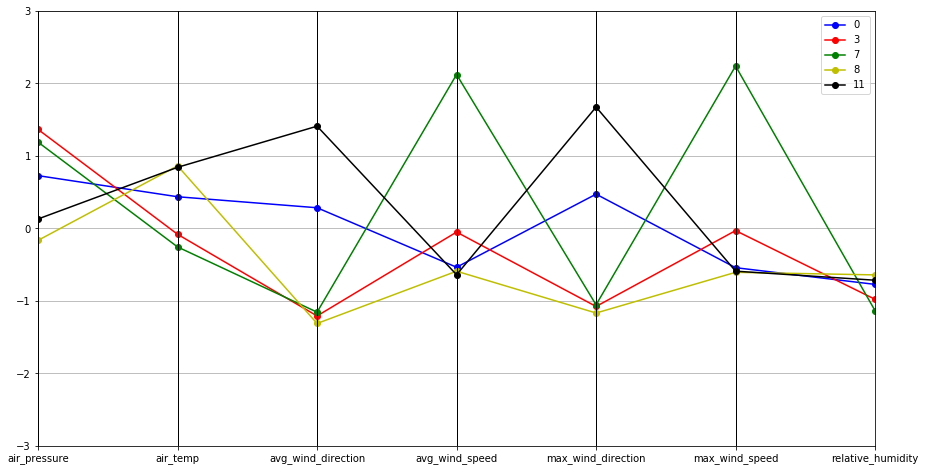

In [96]:
#Plot dos dias de seca, ou seja, cuja humidade relativa do ar foi baixa(< -0.5)
parallel_plot(P[P['relative_humidity'] < -0.5])

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
    Warm Days
</p>

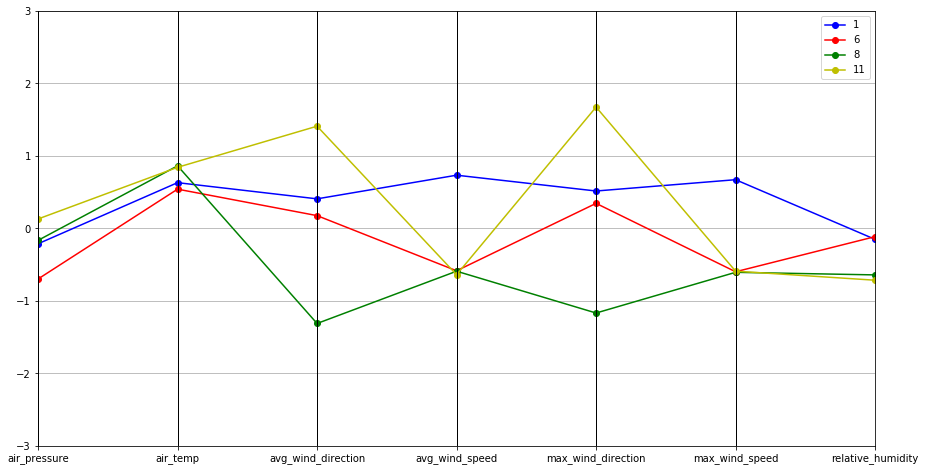

In [97]:
#Plot dos dias quentes, com temperatura do ar acima de 0.5
parallel_plot(P[P['air_temp'] > 0.5])

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
    Cool Days
</p>

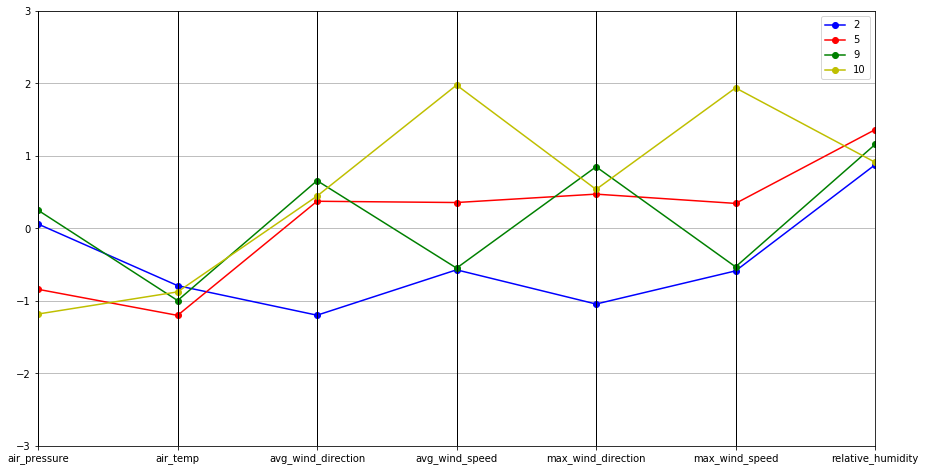

In [98]:
#Plot dos dias frios, com humidade relativa do ar > 0.5 e temperatura do ar < 0.5
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])